In [1]:
!pip install -q langchain sentencepiece plotly minijinja pyautogen markdownify pathvalidate puremagic mammoth python-pptx torchaudio pandas datasets google-search-results pydub easyocr pypdf

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from dotenv import load_dotenv
import datasets

load_dotenv(override=True)
pd.set_option("max_colwidth", None)

OUTPUT_DIR = "output_gaia"

/Users/aymeric/venvs/disposable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from huggingface_hub import login
import os

login(os.getenv("HUGGINGFACEHUB_API_TOKEN"))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/aymeric/.cache/huggingface/token
Login successful


In [5]:
from scripts.web_surfer import (
    browser,
    SearchInformationTool,
    NavigationalSearchTool,
    VisitTool,
    DownloadTool,
    PageUpTool,
    PageDownTool,
    FinderTool,
    FindNextTool,
)

WEB_TOOLS = [
    SearchInformationTool(),
    NavigationalSearchTool(),
    VisitTool(),
    DownloadTool(),
    PageUpTool(),
    PageDownTool(),
    FinderTool(),
    FindNextTool(),
]

Neither powershell nor pwsh is installed.


In [6]:
assert "find_on_page" in dir(
    browser
), "Find on page not found, install latest autogen from source"

In [7]:
from transformers.agents import HfEngine

llm_engine = HfEngine(model="meta-llama/Meta-Llama-3-70B-Instruct")

In [8]:
from datasets import concatenate_datasets

eval_ds = datasets.load_dataset("gaia-benchmark/GAIA", "2023_all")["validation"]
eval_ds = eval_ds.rename_columns(
    {"Question": "question", "Final answer": "true_answer", "Level": "task"}
)
# eval_ds_1 = eval_ds.filter(lambda x: (x["task"] in ["1"])).select(range(30))
# eval_ds_2 = eval_ds.filter(lambda x: (x["task"] in ["2"])).select(range(30))
# eval_ds = concatenate_datasets([eval_ds_1, eval_ds_2])


def preprocess_file_paths(row):
    if len(row["file_name"]) > 0:
        row["file_name"] = "data/gaia/validation/" + row["file_name"]
    return row


eval_ds = eval_ds.map(preprocess_file_paths)

eval_df = pd.DataFrame(eval_ds)

In [9]:
pd.Series(eval_ds["task"]).value_counts()

2    86
1    53
3    26
Name: count, dtype: int64

### Define tools

In [10]:
from transformers.agents import ReactJsonAgent, HfEngine
from scripts.prompts import WEB_SURFER_PROMPT

websurfer_llm_engine = HfEngine(
    model="CohereForAI/c4ai-command-r-plus"
)  # chosen for its high context length

surfer_agent = ReactJsonAgent(
    llm_engine=websurfer_llm_engine,
    tools=WEB_TOOLS,
    max_iterations=8,
    verbose=1,
    system_prompt=WEB_SURFER_PROMPT,
)

In [11]:
cleaned_df = pd.read_json(
    "output_gaia/react_code_llama3-70b_02-05_full-gaia-validation-code.jsonl",
    lines=True,
)
print(len(cleaned_df))
cleaned_df = cleaned_df.loc[
    cleaned_df["intermediate_steps"].apply(
        lambda s: "Chat template must be a string" not in str(s)
        and "Model is overloaded." not in str(s)
        and "in 'if/else' conditions" not in str(s)
        # and "Stream has ended unexpectedly" not in str(s)
        and "Payload Too Large" not in str(s)
        and "Cannot read an empty file" not in str(s)
    )
]
print(len(cleaned_df))

# cleaned_df.to_json(
#     "output_gaia/react_code_llama3-70b_02-05_full-gaia-validation-code.jsonl",
#     orient="records",
#     lines=True,
# )

165
165


/Users/aymeric/venvs/disposable/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


./data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png
{'inputs': 'User: What is the oldest Blu-Ray sold?<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}
{'generated_text': ' The oldest Blu-Ray sold is "The Keanu Reeves Story."'}
The algorithm to eﬃciently ﬁnd MPS representations
of Floquet eigenstates introduced in this paper is a gener-
alization of the DMRG-X algorithm for static MBL sys-
tems.

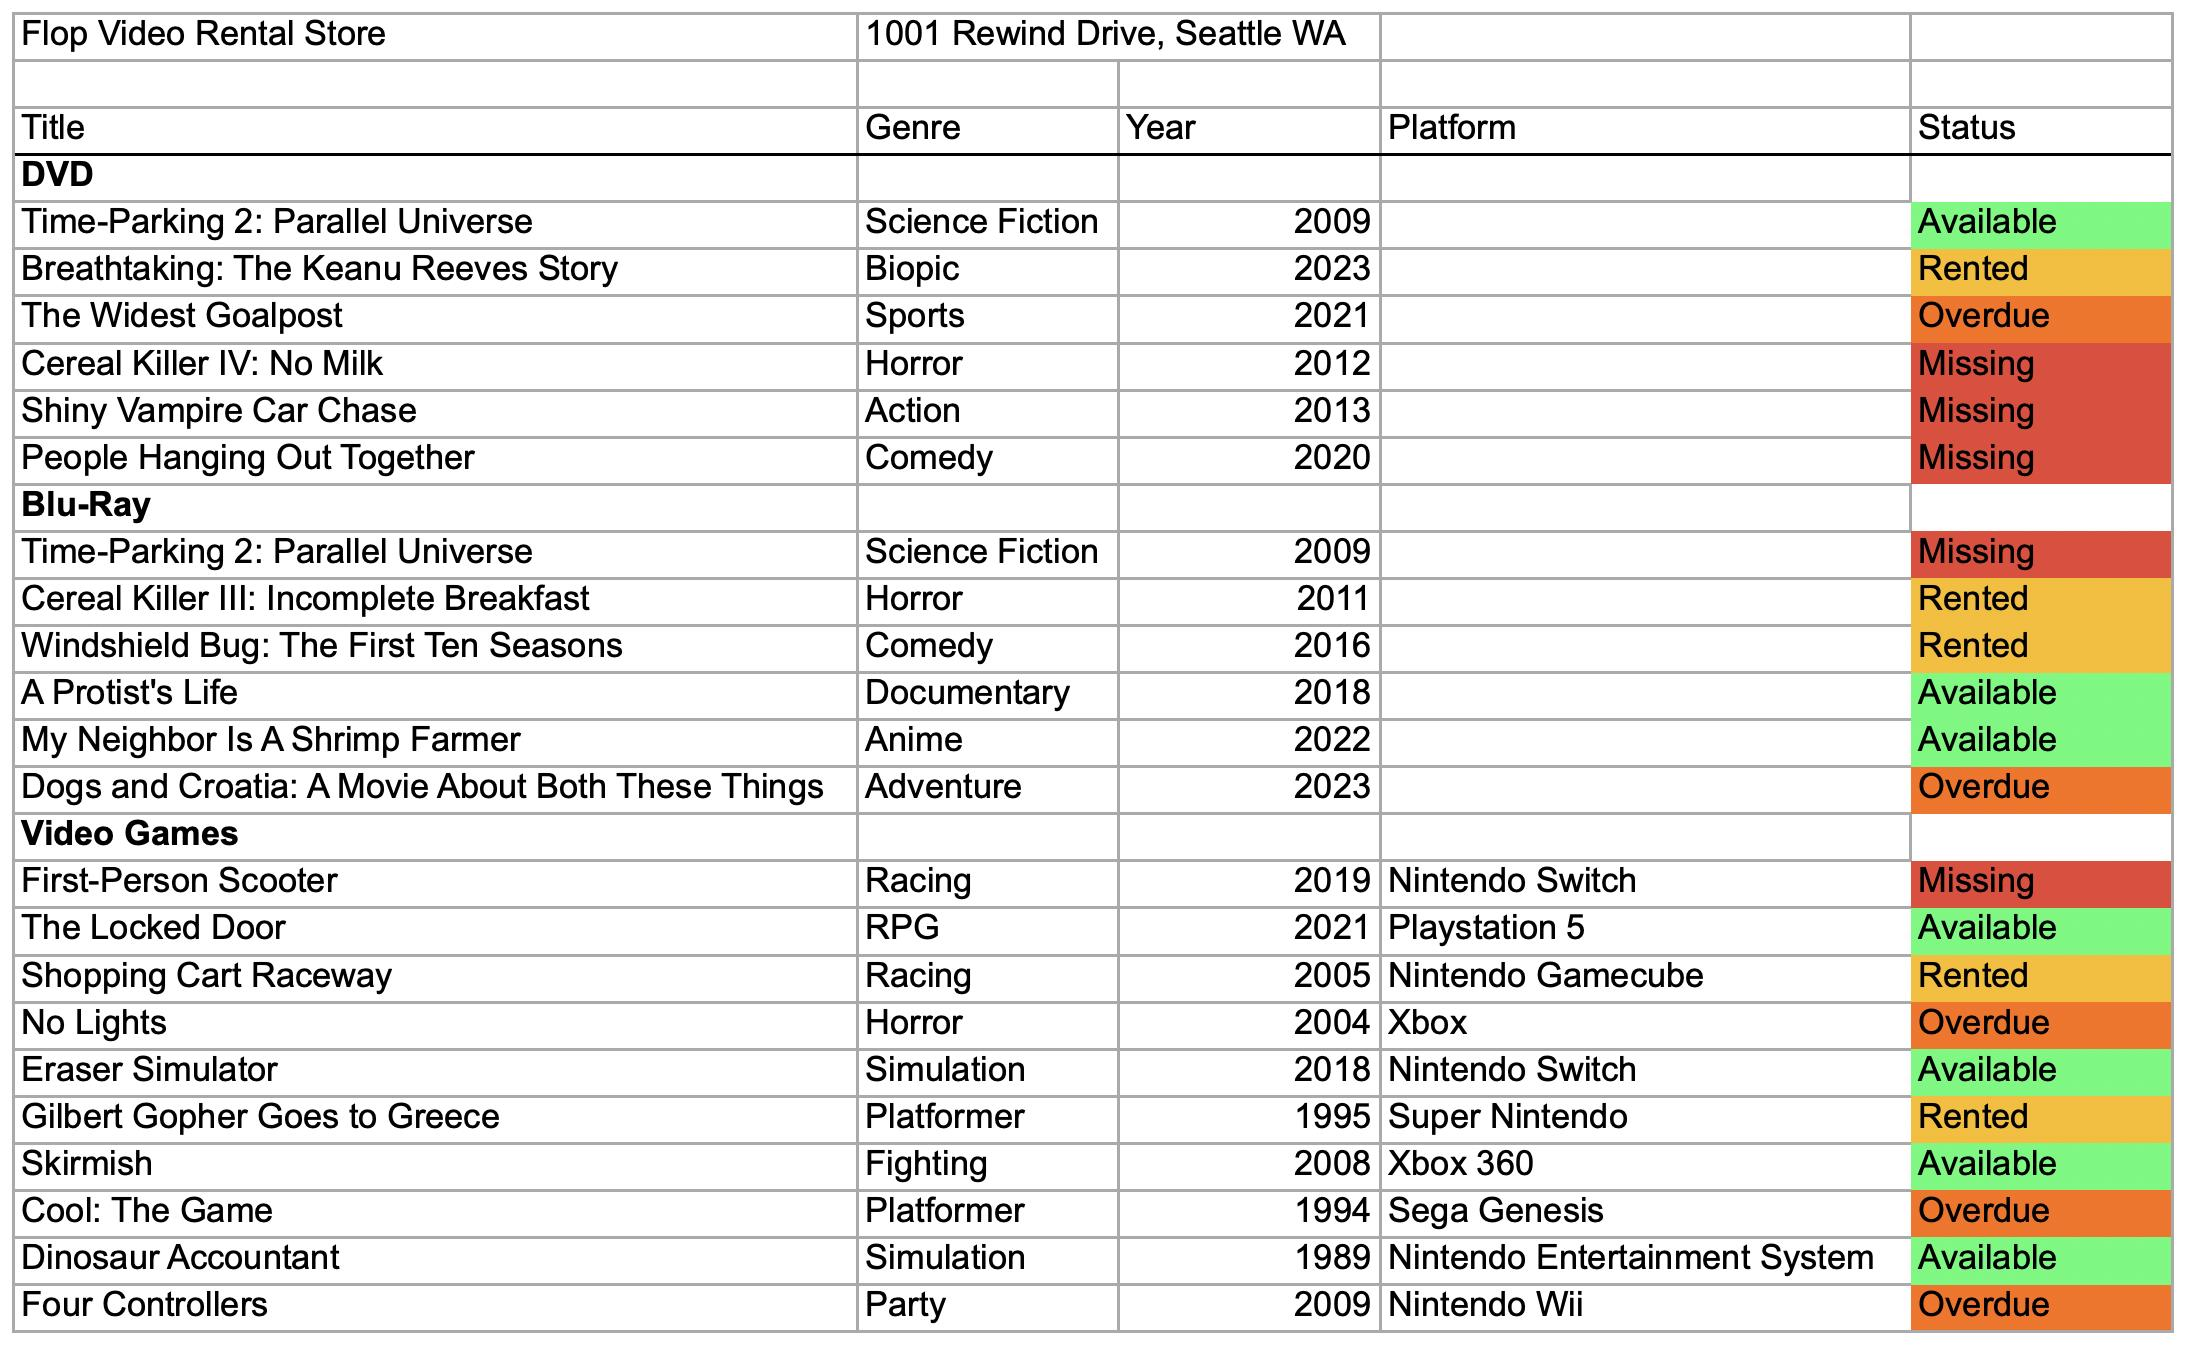

In [12]:
from transformers.agents.default_tools import Tool
from langchain_community.utilities import SerpAPIWrapper
from pypdf import PdfReader
from markdownify import markdownify as md
import requests
from huggingface_hub import InferenceClient
from scripts.visual_qa import process_images_and_text

params = {
    "engine": "bing",
    "gl": "us",
    "hl": "en",
}
langchain_serpapi = SerpAPIWrapper(params=params)


class  (Tool):
    name = "search"
    description = (
        "A search engine. Lets you browse the Internet to search for information."
    )

    inputs = {"query": {"description": "your search query", "type": "text"}}
    output_type = "text"

    def forward(self, query: str) -> str:
        return langchain_serpapi.run(query)


class SearchTool(Tool):
    name = "ask_search_agent"
    description = "A search agent that will browse the internet to answer a question. Use it to gather informations, not for problem-solving."

    inputs = {
        "question": {
            "description": "Your question, as a natural language sentence. You are talking to an human, so provide them with as much context as possible.",
            "type": "text",
        }
    }
    output_type = "text"

    def forward(self, question: str) -> str:
        return surfer_agent.run(question)


def extract_text_from_pdf(pdf_path):
    pdf = PdfReader(pdf_path)
    text = ""
    for page in pdf.pages:
        text += page.extract_text()
    return md(text)


class TextInspectorTool(Tool):
    name = "inspect_file_as_text"
    description = "You cannot load files yourself: instead call this tool to read a file as text and ask questions about it."

    inputs = {
        "question": {
            "description": "Your question, as a natural language sentence. Provide as much context as possible.",
            "type": "text",
        },
        "file_path": {
            "description": "The path to the file you want to read as text. Must be a '.something' file, like '.pdf'. If it is an image, use the visualizer tool instead! If it's a webpage, use the web browser tool instead!",
            "type": "text",
        },
    }
    output_type = "text"

    def forward(self, question: str, file_path) -> str:
        if "http" in file_path:
            if "arxiv" in file_path:
                file_path = file_path.replace("abs", "pdf")
            response = requests.get(file_path)
            new_path = "/tmp/metadata.pdf"
            with open(new_path, "wb") as f:
                f.write(response.content)
                text = extract_text_from_pdf(new_path)
        elif file_path.split(".")[-1] == "pdf":
            text = extract_text_from_pdf(file_path)
        else:
            text = ""
            with open(file_path, "r") as f:
                while True:
                    line = f.readline()
                    if (not line) or (len(text) > 20000):
                        break
                    text += line

        messages = [
            {
                "role": "user",
                "content": "You will have to solve the following question with the below context: "
                + question,
            },
            {
                "role": "user",
                "content": "Here is the context:\n" + text,
            },
        ]
        return websurfer_llm_engine(messages)


from PIL import Image


def resize_image(image_path):
    img = Image.open(image_path)
    width, height = img.size
    img = img.resize((int(width / 2), int(height / 2)))
    new_image_path = f"resized_{image_path}"
    img.save(new_image_path)
    return new_image_path


class VisualQATool(Tool):
    name = "visualizer"
    description = "A tool that can answer questions about attached images."
    inputs = {
        "question": {"description": "the question to answer", "type": "text"},
        "image_path": {
            "description": "The path to the image on which to answer the question",
            "type": "text",
        },
    }
    output_type = "text"

    client = InferenceClient(
        "HuggingFaceM4/idefics2-8b-chatty"
    )

    def forward(self, question: str, image_path: str) -> str:
        try:
            return process_images_and_text(image_path, question, self.client)
        except Exception as e:
            print(e)
            if "Payload Too Large" in str(e):
                new_image_path = resize_image(image_path)
                return process_images_and_text(new_image_path, question, self.client)


# Let's test our tools!

visualizer = VisualQATool()
image_path = "./data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png"
print(visualizer(question="What is the oldest Blu-Ray sold?", image_path=image_path))

from transformers.agents import SpeechToTextTool

stt_tool = SpeechToTextTool()

# audio_path = "./data/gaia/validation/2b3ef98c-cc05-450b-a719-711aee40ac65.mp3"

# print(stt_tool(audio_path))


titool = TextInspectorTool()
print(
    titool(
        question="Could you cite the content at the beginning of page 4 of this document?",
        file_path="https://arxiv.org/pdf/1608.06411",
    )
)

In [13]:
from transformers.agents import PythonInterpreterTool

TASK_SOLVING_TOOLBOX = [
    SearchTool(),
    VisualQATool(),
    SpeechToTextTool(),
    TextInspectorTool(),
    # PythonInterpreterTool(),
]

# Define agents

In [34]:
from transformers.agents import ReactCodeAgent, HfEngine
from scripts.prompts import GAIA_PROMPT

llm_engine = HfEngine(model="meta-llama/Meta-Llama-3-70B-Instruct")
react_agent_hf = ReactCodeAgent(
    llm_engine=llm_engine,
    tools=TASK_SOLVING_TOOLBOX,
    max_iterations=7,
    verbose=0,
    memory_verbose=True,
    system_prompt=GAIA_PROMPT,
)

In [35]:
async def call_transformers(agent, question: str, **kwargs) -> str:
    result = agent.run(question, **kwargs)
    print(type(result))
    return {
        "output": str(result),
        "intermediate_steps": [
            {key: value for key, value in log.items() if key != "agent_memory"}
            for log in agent.logs
        ],
    }

In [16]:
assert False

AssertionError: 

In [ ]:
res = await call_transformers(
    react_agent_hf,
    "What is the 7th FIbonacci number?",
    image_path="data/gaia/validation/1.png",
)
res

In [ ]:
assert False

/Users/aymeric/Documents/Code/agent_reasoning_benchmark/scripts/run_agents.py:196: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results = pd.read_json(output_path, lines=True).to_dict(orient="records")


Expected object or value
Found no usable records! 🤔 Starting new.


  0%|          | 0/165 [00:00<?, ?it/s]======== New task ========
A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure with three axes, where each axis has a label word at both ends. Which of these words is used to describe a type of society in a Physics and Society article submitted to arXiv.org on August 11, 2016?
==== Agent is executing the code below:
paper_description = ask_search_agent(question="What is the description of the figure in the AI regulation paper submitted to arXiv.org in June 2022?")
print("Paper description:", paper_description)
====
======== New task ========
What is the description of the figure in the AI regulation paper submitted to arXiv.org in June 2022?
Calling tool: 'informational_web_search' with arguments: {'query': 'AI regulation paper arXiv.org June 2022'}
Calling tool: 'visit_page' with arguments: {'url': 'https://arxiv.org/abs/2306.00292'}
Calling tool: 'final_answer' with arguments: {'answer': "Here is th

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
species = ask_search_agent(question="What species of fish was popularized by the movie Finding Nemo?")
print(" Species:", species)
====
======== New task ========
What species of fish was popularized by the movie Finding Nemo?
Calling tool: 'informational_web_search' with arguments: {'query': 'type of fish in Finding Nemo'}
Calling tool: 'informational_web_search' with arguments: {'query': 'scientific name clownfish'}
Calling tool: 'final_answer' with arguments: {'answer': 'Clownfish, or Amphiprion ocellaris (also referred to as Amphiprioninae in some sources), was popularized by the movie Finding Nemo.'}
Print outputs:
 Species: Clownfish, or Amphiprion ocellaris (also referred to as Amphiprioninae in some sources), was popularized by the movie Finding Nemo.

==== Agent is executing the code below:
non_native_locations = ask_search_agent(question="According to the USGS, where was Amphiprion ocellaris found as a nonnative species before 2020?")
p

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
num_articles = ask_search_agent(question="How many articles were published by Nature in 2020?")
print("Number of articles:", num_articles)
====
======== New task ========
How many articles were published by Nature in 2020?
Calling tool: 'informational_web_search' with arguments: {'query': 'Number of articles published by Nature in 2020'}
Calling tool: 'final_answer' with arguments: {'answer': 'Nature published 502 journal articles in Nature Medicine in 2020.'}
Print outputs:
Number of articles: Nature published 502 journal articles in Nature Medicine in 2020.

==== Agent is executing the code below:
total_articles = ask_search_agent(question="How many articles were published by Nature in 2020, across all its journals?")
print("Total number of articles:", total_articles)
====
======== New task ========
How many articles were published by Nature in 2020, across all its journals?
Calling tool: 'informational_web_search' with arguments: {'query': 'ho

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
answer = ask_search_agent(question="How to correct the Unlambda code to output 'For penguins' from 'r
====
Failed while trying to execute the code below:
answer = ask_search_agent(question="How to correct the Unlambda code to output 'For penguins' from 'r
This failed due to the following error:
The code generated by the agent is not valid.
unterminated string literal (detected at line 1) (<unknown>, line 1)
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/python_interpreter.py", line 502, in evaluate_python_code
    expression = ast.parse(code)
  File "/opt/homebrew/Cellar/python@3.10/3.10.14/Frameworks/Python.framework/Versions/3.10/lib/python3.10/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 1
    answer = ask_search_agent(question="How to correct the Unlambda code to output 'For penguins' from 'r
          

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
distance_to_moon = ask_search_agent(question="What is the minimum perigee value of the Moon on its wikipedia page?")
print("Distance to Moon:", distance_to_moon)

marathon_pace = ask_search_agent(question="What is Eliud Kipchoge's record-making marathon pace?")
print("Marathon Pace:", marathon_pace)
====
======== New task ========
What is the minimum perigee value of the Moon on its wikipedia page?
Calling tool: 'navigational_web_search' with arguments: {'query': 'Moon perigee wikipedia'}
Calling tool: 'final_answer' with arguments: {'answer': 'The minimum perigee value of the Moon is approximately 225,802 miles, or 356,400 km.'}
======== New task ========
What is Eliud Kipchoge's record-making marathon pace?
Calling tool: 'informational_web_search' with arguments: {'query': 'eliud kipchoge record-making marathon pace'}
Calling tool: 'navigational_web_search' with arguments: {'query': 'eliud kipchoge record-making marathon'}
Calling tool: 'final_

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
data = visualizer(question="What is the data in the spreadsheet?", image_path='data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png')
print("Data:", data)
====


data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png
{'inputs': 'User: What is the data in the spreadsheet?<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}

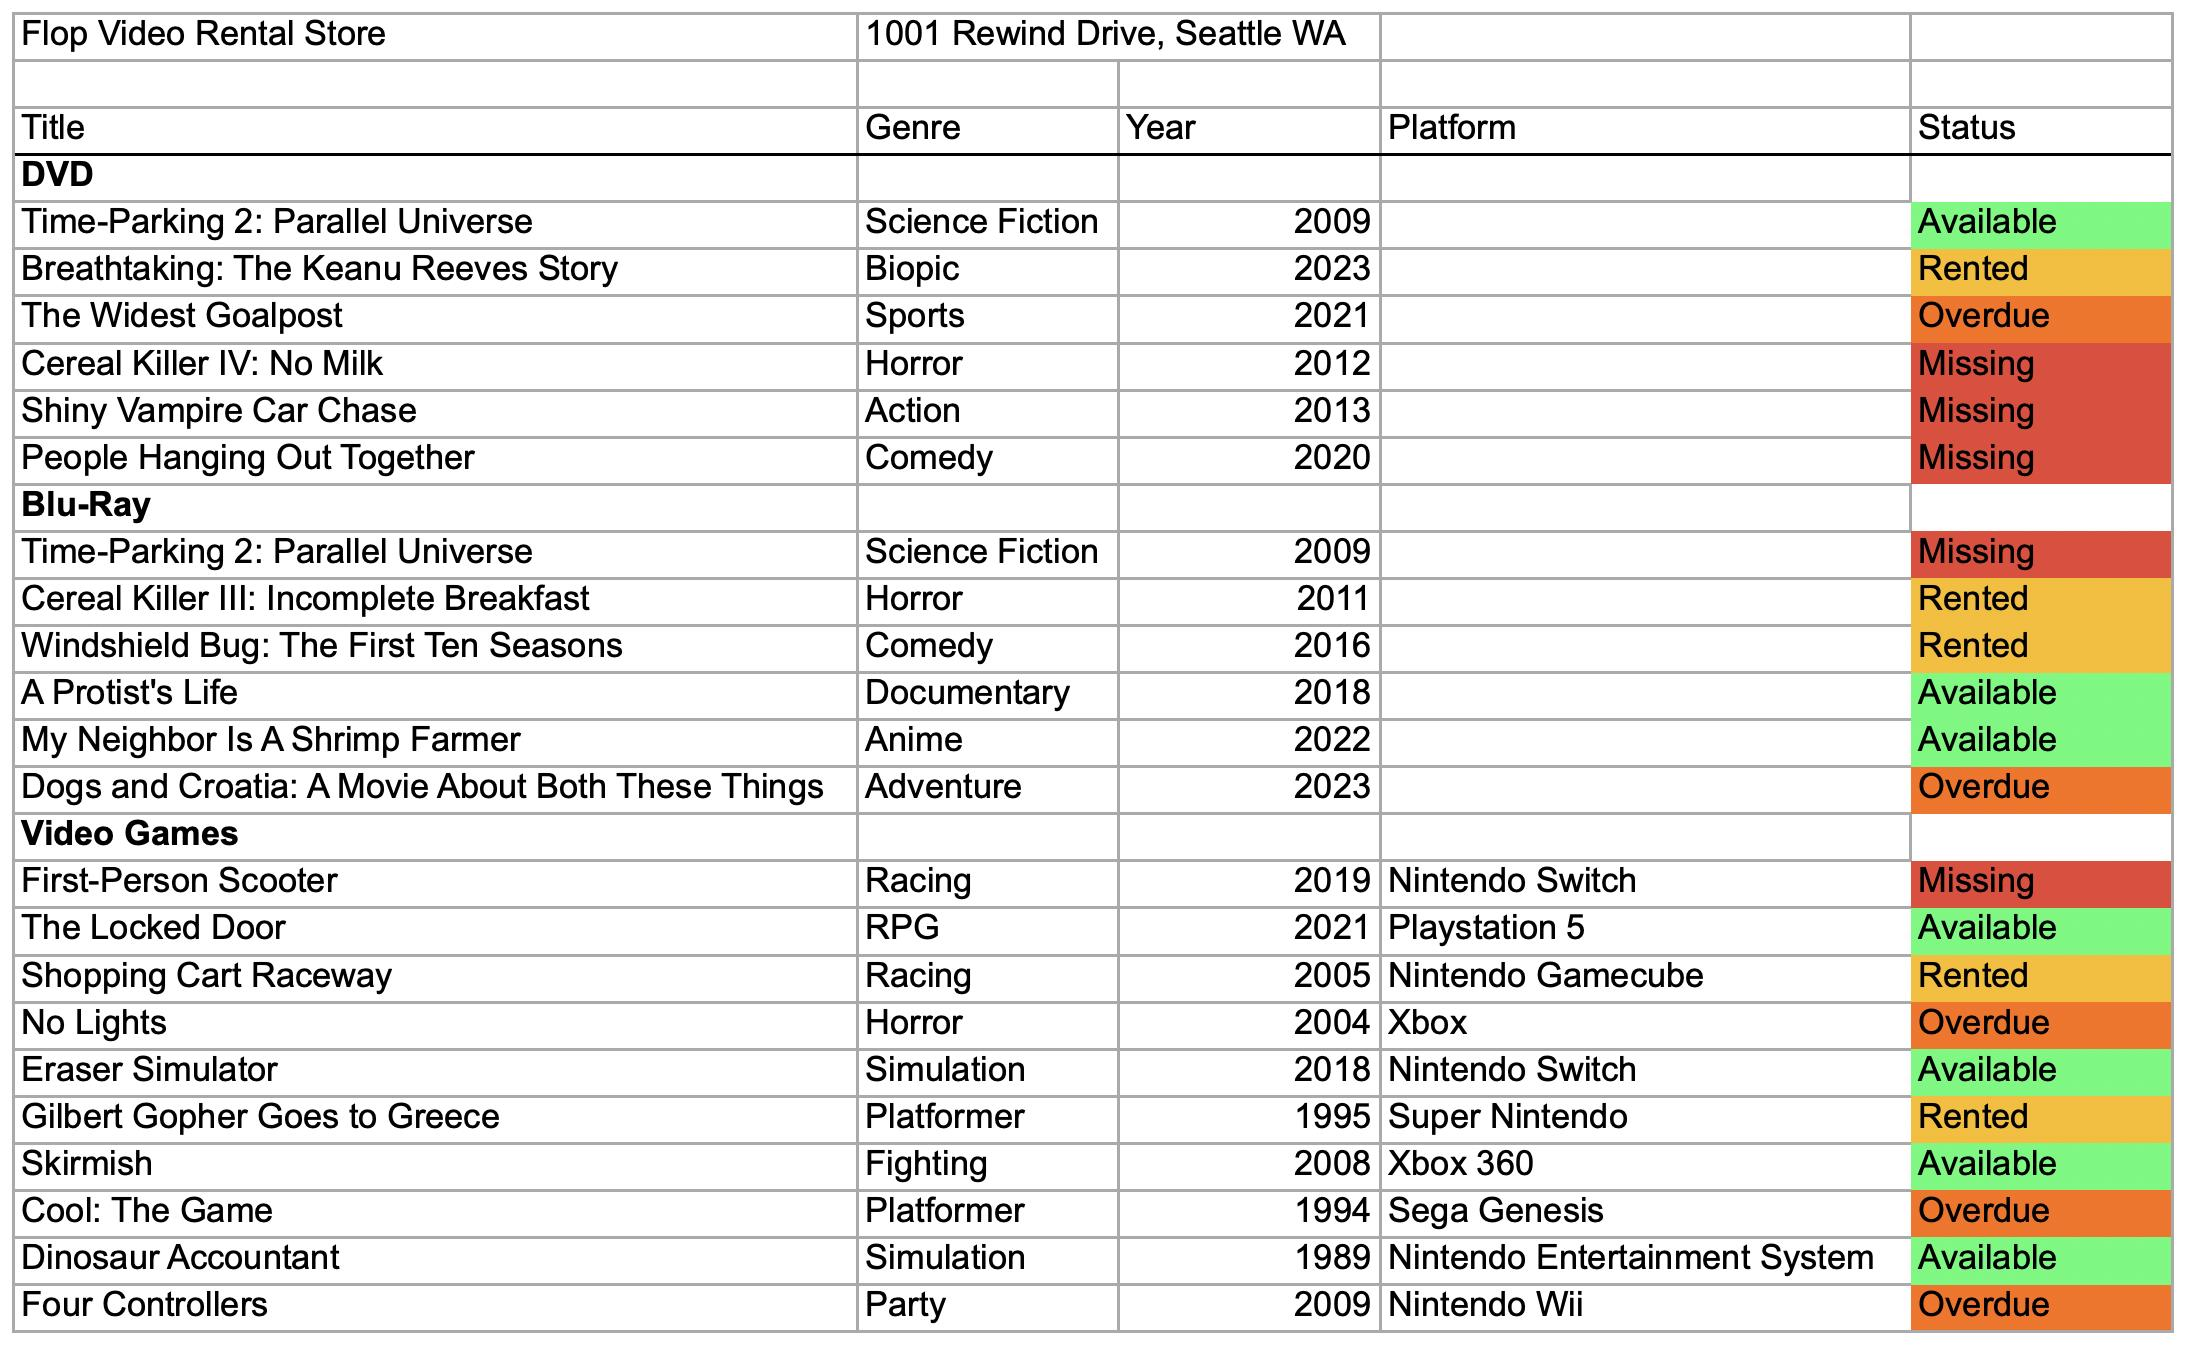

Print outputs:
Data: {'generated_text': ' The data in the spreadsheet includes information about various video games, such as their titles, platforms, release years, and availability.'}

==== Agent is executing the code below:
data = visualizer(question="What is the content of each cell in the spreadsheet?", image_path='data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png')
print("Data:", data)
====


data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png
{'inputs': 'User: What is the content of each cell in the spreadsheet?<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}

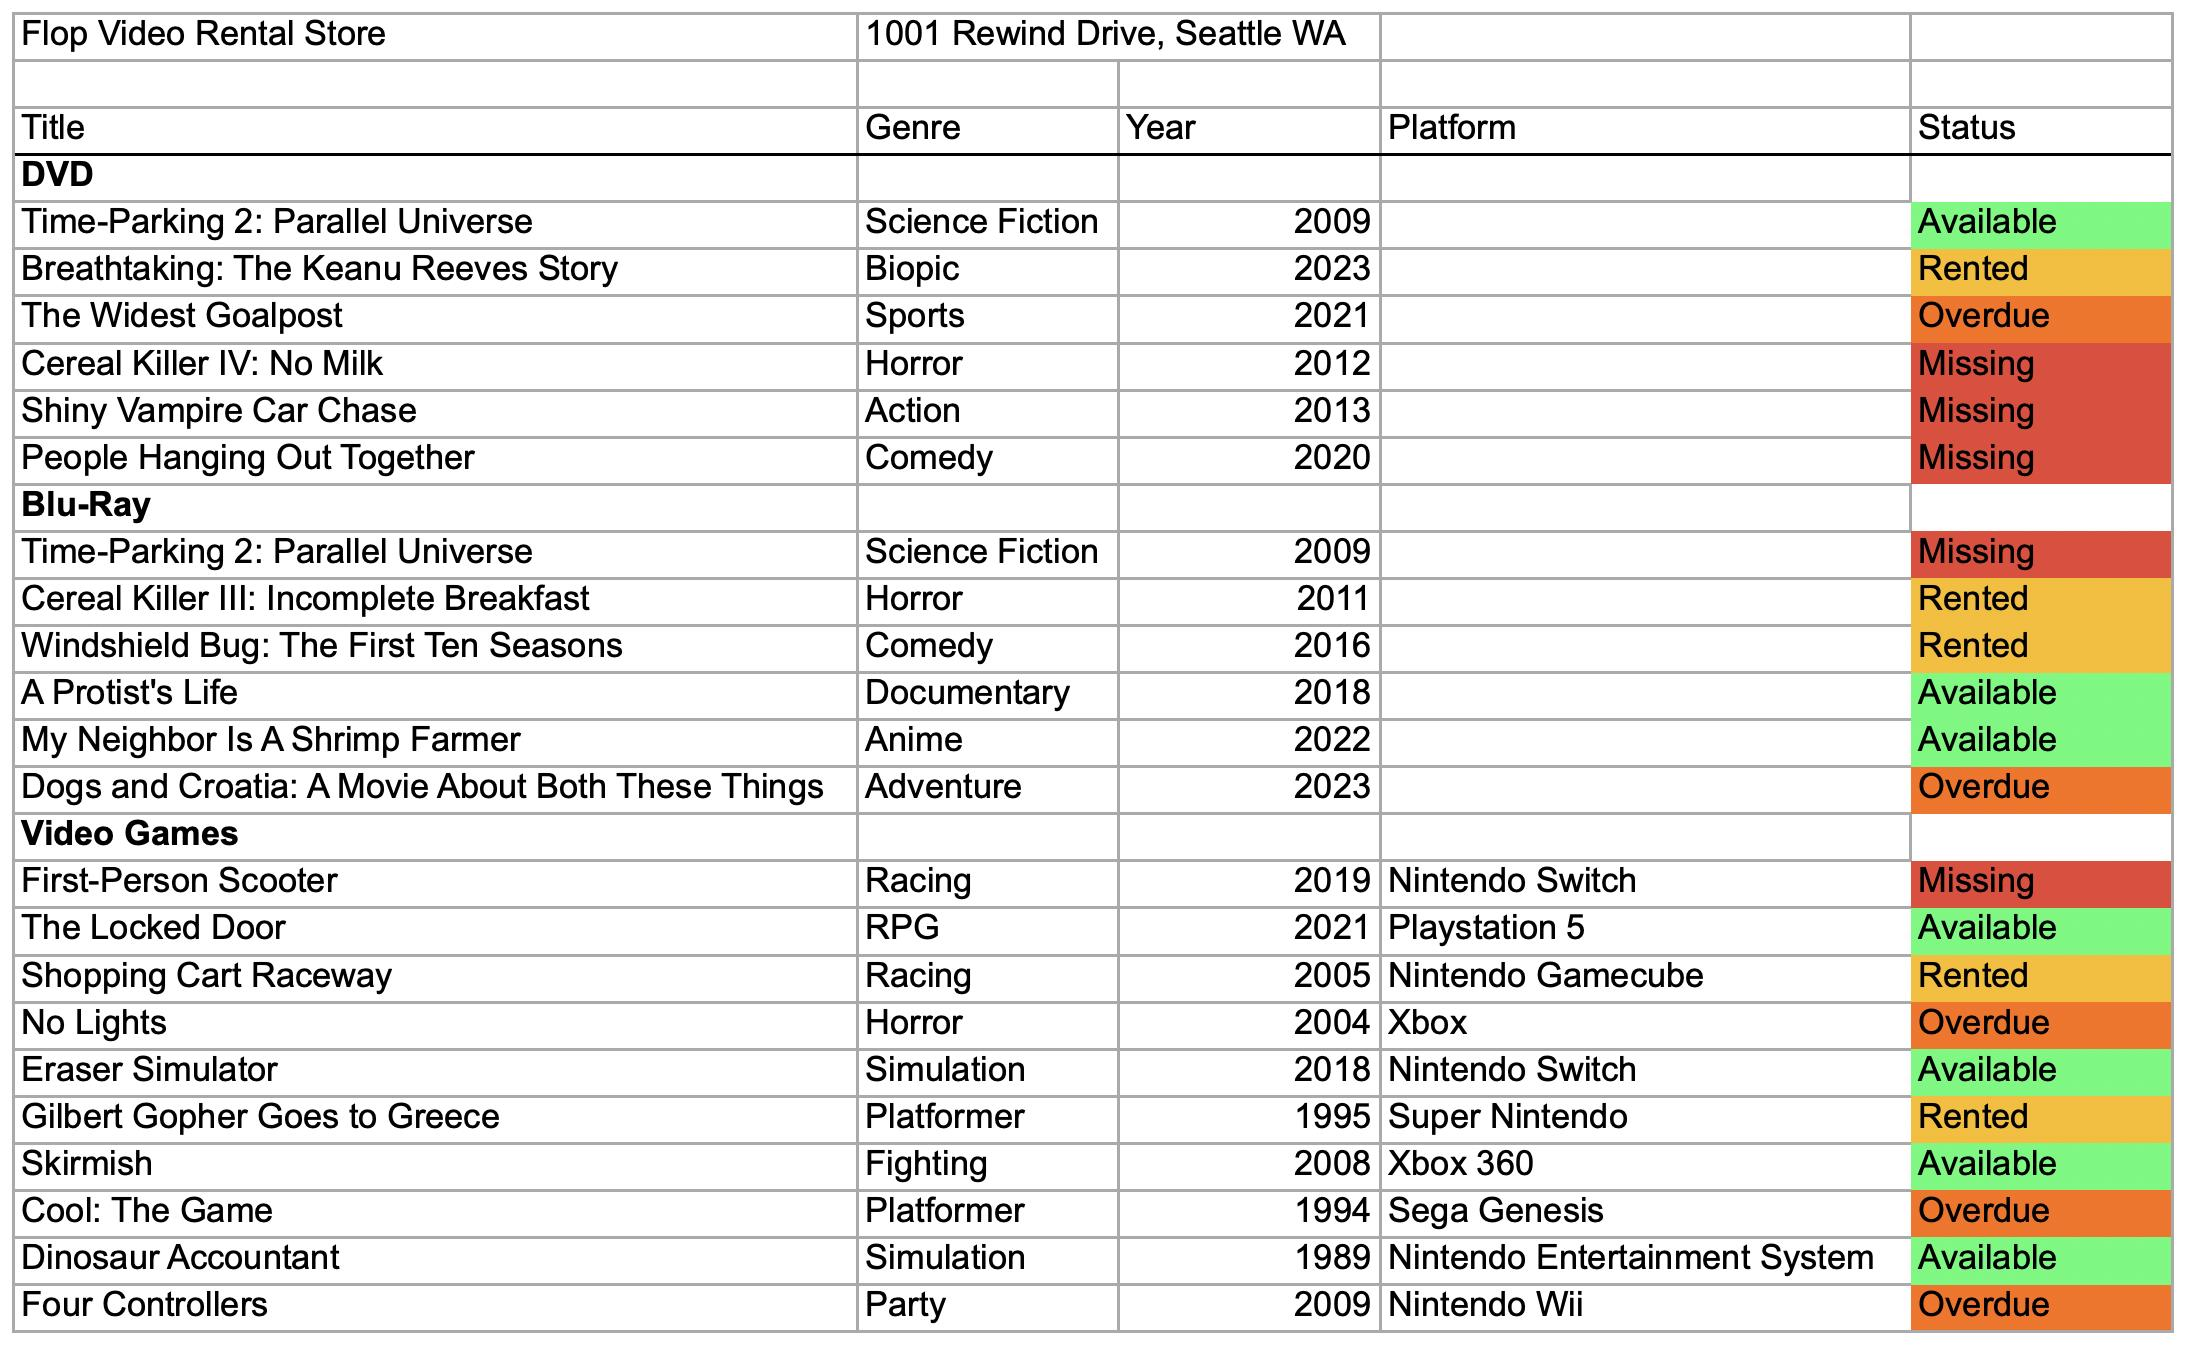

Print outputs:
Data: {'generated_text': ' The content of each cell in the spreadsheet represents the title of a video game, its platform, and its status. The platform is either "1001 Rewind Drive, Seattle WA" or "Available Overdue".'}

==== Agent is executing the code below:
method = ask_search_agent(question="How can I extract data from an image of a spreadsheet?")
print("Method:", method)
====
======== New task ========
How can I extract data from an image of a spreadsheet?
Calling tool: 'informational_web_search' with arguments: {'query': 'how to extract data from image of spreadsheet'}
Calling tool: 'navigational_web_search' with arguments: {'query': 'how to extract data from image of spreadsheet in google sheets'}
Calling tool: 'navigational_web_search' with arguments: {'query': 'how to use bardeen to extract data from an image in google sheets'}
Calling tool: 'final_answer' with arguments: {'answer': "Bardeen is an AI powered Chrome Extension that can automate various tasks. Ther

data/gaia/validation/32102e3e-d12a-4209-9163-7b3a104efe5d.png
{'inputs': 'User: What are the titles and release years of the Blu-Ray discs in the spreadsheet?<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}

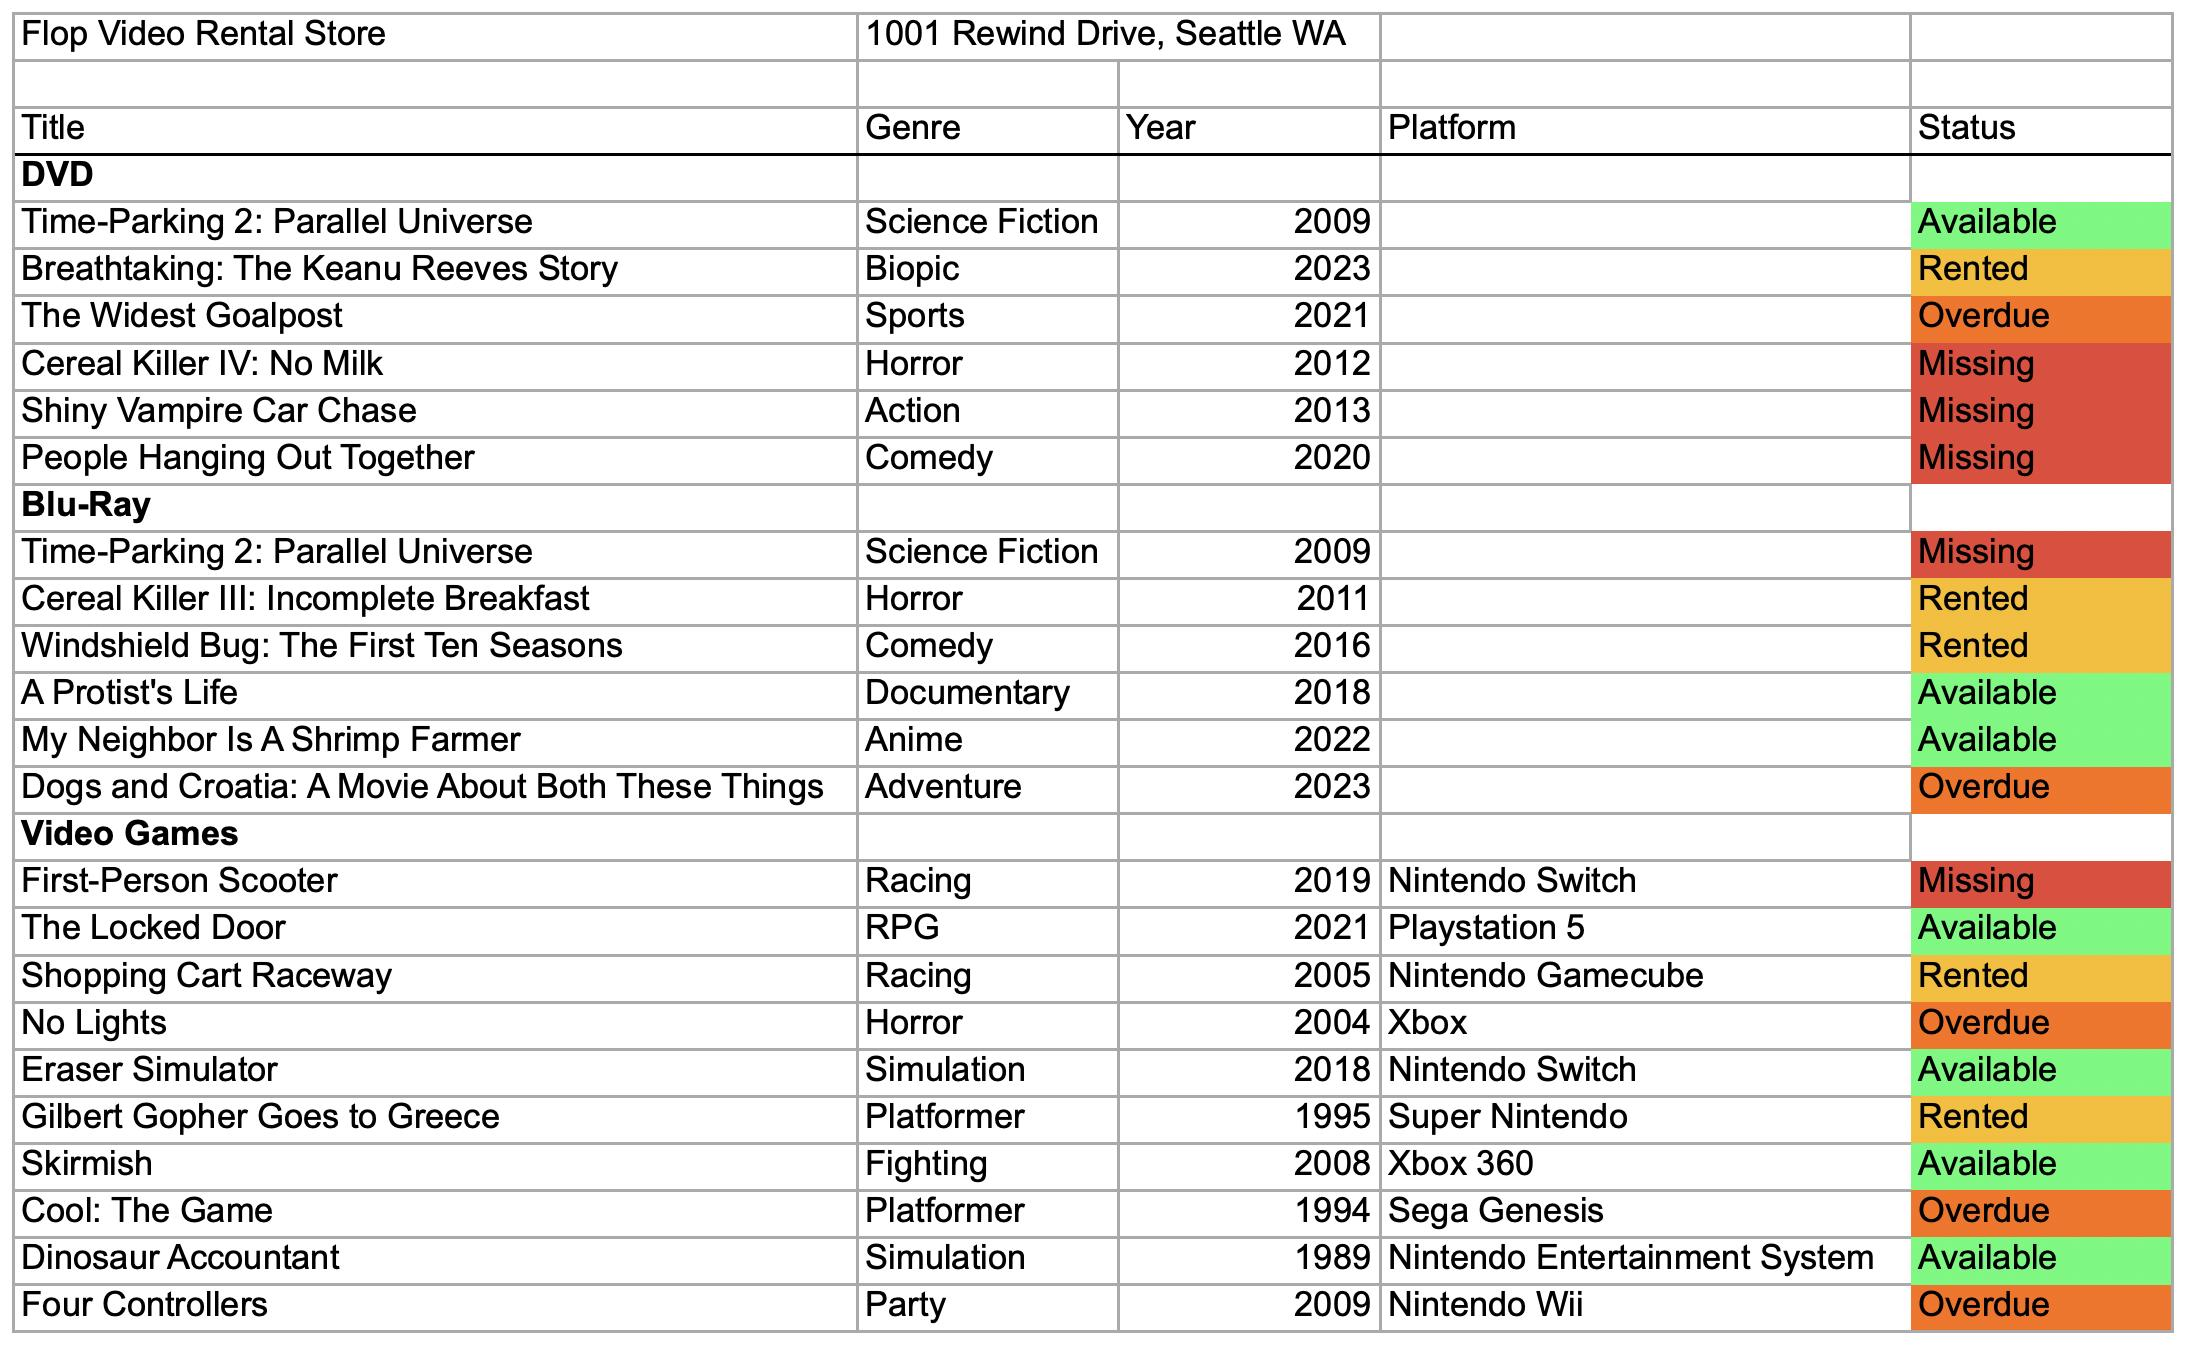

Print outputs:
Data: {'generated_text': ' The Blu-Ray discs in the spreadsheet are "The Keanu Reeves Story," "The Lockdown," "The Keanu Reeves Collection," "The Windiest Goalpost," "The No Lights," "The Eraser Simulator," "The Skirmish," "The Game," "The Dinosaur Accountant," "The Four Controllers," and "The Windshield Bug: The First Ten Seasons."'}

==== Agent is executing the code below:
release_years = []
for title in ["The Keanu Reeves Story", "The Lockdown", "The Keanu Reeves Collection", "The Windiest Goalpost", "The No Lights", "The Eraser Simulator", "The Skirmish", "The Game", "The Dinosaur Accountant", "The Four Controllers", "The Windshield Bug: The First Ten Seasons"]:
    year = ask_search_agent(question=f"What is the release year of the Blu-Ray '{title}'?")
    release_years.append((title, year))
print("Release Years:", release_years)
====
======== New task ========
What is the release year of the Blu-Ray 'The Keanu Reeves Story'?
Calling tool: 'informational_web_search' 

<class 'str'>


==== Agent is executing the code below:
answer = ask_search_agent(question="What are the studio albums by Mercedes Sosa between 2000 and 2009?")
print("Studio albums by Mercedes Sosa between 2000 and 2009:", answer)
====
======== New task ========
What are the studio albums by Mercedes Sosa between 2000 and 2009?
Calling tool: 'informational_web_search' with arguments: {'query': 'Mercedes Sosa discography'}
Could not parse the given action: The JSON blob you used is invalid: due to the following error: Extra data: line 6 column 6 (char 139). JSON blob was: {
        "action": "visit_page",
        "action_input": {
            "url": "https://www.mercedes-sosa.com/discographie"
        }
    },
    {
        "action": "visit_page",
        "action_input": {
            "url": "https://www.mercedes-sosa.com/discografia"
        }
    }, decoding failed at '   },
   '..
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transfo

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
article_abstract = ask_search_agent(question="What is the abstract of the research article published in Science Advances in 2021 that mentions the mollusk species with the museum number 2012,5015.17?")
print("Article abstract:", article_abstract)
====
======== New task ========
What is the abstract of the research article published in Science Advances in 2021 that mentions the mollusk species with the museum number 2012,5015.17?
Calling tool: 'informational_web_search' with arguments: {'query': 'Science Advances paper 2021 mollusk museum number 2012,5015.17'}
Calling tool: 'informational_web_search' with arguments: {'query': 'Science Advances mollusk 2021'}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.science.org/doi/10.1126/sciadv.abi8620'}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.science.org/doi/10.1126/sciadv.abi8620', 'javascript': True}
Error in tool call execution: VisitTool.forward() got an unexpec

<class 'str'>


==== Agent is executing the code below:
answer = ask_search_agent(question="What is the oldest closed numpy-polynomial issue with the Regression label on GitHub?")
print("Oldest issue:", answer)
====
======== New task ========
What is the oldest closed numpy-polynomial issue with the Regression label on GitHub?
Calling tool: 'navigational_web_search' with arguments: {'query': 'numpy-polynomial Regression issues github'}
Calling tool: 'navigational_web_search' with arguments: {'query': 'regression issues numpy-polynomial github repository'}
Calling tool: 'navigational_web_search' with arguments: {'query': 'numpy-polynomial github repository'}
Calling tool: 'visit_page' with arguments: {'url': 'https://github.com/jonathf/numpoly/issues?q=is%3Aissue+is%3Aclosed+label%3Aregression'}
Calling tool: 'visit_page' with arguments: {'url': 'https://github.com/jonathf/numpoly/issues/45'}
Calling tool: 'final_answer' with arguments: {'answer': "The oldest closed numpy-polynomial issue with the Regr

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
# Initialize the ramp with 100 balls
ramp = list(range(1, 101))

# Initialize the platform with the first three balls
platform = ramp[:3]

# Remove the first three balls from the ramp
ramp = ramp[3:]

# Simulate the game
ejected_balls = []
while ramp:
    # Randomly select a piston to fire
    piston = random.randint(1, 3)
    
    # Eject the ball
    if piston == 1:
        ejected_balls.append(platform.pop(0))
        platform.append(ramp.pop(0))
    elif piston == 2:
        ejected_balls.append(platform.pop(1))
        platform = [platform[1], ramp.pop(0), ramp.pop(0)]
    elif piston == 3:
        ejected_balls.append(platform.pop(2))
        platform = [platform[0], ramp.pop(0), ramp.pop(0)]

# Count the frequency of each ball being ejected
ejection_counts = {ball: ejected_balls.count(ball) for ball in range(1, 101)}

# Find the ball with the highest ejection count
best_ball = max(ejection_counts, key=ejection_counts.get)
print("Best ball:

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
standards_1959 = ask_search_agent(question="What are the United States standards for grades of processed fruits, vegetables, and certain other products listed as dehydrated as of July 2, 1959?")
print("Standards 1959:", standards_1959)
standards_2023 = ask_search_agent(question="What are the United States standards for grades of processed fruits, vegetables, and certain other products listed as dehydrated as of August 2023?")
print("Standards 2023:", standards_2023)
====
======== New task ========
What are the United States standards for grades of processed fruits, vegetables, and certain other products listed as dehydrated as of July 2, 1959?
Calling tool: 'informational_web_search' with arguments: {'query': 'US standards for grades of processed fruits, vegetables 1959'}
Calling tool: 'visit_page' with arguments: {'url': 'https://archive.org/details/unitedstatesstan14unit_4'}
Calling tool: 'visit_page' with arguments: {'url': 'https://archive.or

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
pdb_text = inspect_file_as_text(question="read the file", file_path=attached_file_path)
print("PDB text:", pdb_text)
====
Print outputs:
PDB text: This file is a Protein Data Bank (PDB) formatted file, that contains atomic coordinates and other experimental data for a protein. The file describes the structure of the epidermal growth factor receptor (EGFR) extracellular region in complex with epiregulin, which are both signalling proteins. The structure was determined by X-ray diffraction to a resolution of 2.94 Angstroms

==== Agent is executing the code below:
pdb_text = inspect_file_as_text(question="read the entire file", file_path=attached_file_path)
print("PDB text:", pdb_text)
====
Print outputs:
PDB text: This file contains information about a protein called Epidermal Growth Factor Receptor, or EGFR for short. The file format appears to be a protein data bank (PDB) file, which is commonly used to describe the 3D structure of proteins. EGFR

<class 'str'>


==== Agent is executing the code below:
paper_text = inspect_file_as_text(file_path="paper_about_SPFMV_and_SPCSV_in_the_Pearl_Of_Africa_from_2016.pdf", question="")
print("Paper text:", paper_text)
====
Failed while trying to execute the code below:
paper_text = inspect_file_as_text(file_path="paper_about_SPFMV_and_SPCSV_in_the_Pearl_Of_Africa_from_2016.pdf", question="")
print("Paper text:", paper_text)
This failed due to the following error:
[Errno 2] No such file or directory: 'paper_about_SPFMV_and_SPCSV_in_the_Pearl_Of_Africa_from_2016.pdf'
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 823, in step
    result = self.python_evaluator(code_action, available_tools, state=self.state)
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/python_interpreter.py", line 511, in evaluate_python_code
    line_result = evaluate_ast(node, state, tool

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
place = ask_search_agent(question="What is the first place mentioned by name in the Book of Esther (in the New International Version)?")
print("First place mentioned:", place)
====
======== New task ========
What is the first place mentioned by name in the Book of Esther (in the New International Version)?
Calling tool: 'informational_web_search' with arguments: {'query': 'places mentioned in the Book of Esther'}
Calling tool: 'informational_web_search' with arguments: {'query': 'Persia location'}
Calling tool: 'informational_web_search' with arguments: {'query': 'Susa location'}
Calling tool: 'final_answer' with arguments: {'answer': 'The first places mentioned in the Book of Esther (in the New International Version) are Susa and Persia, modern day Iran.'}
Print outputs:
First place mentioned: The first places mentioned in the Book of Esther (in the New International Version) are Susa and Persia, modern day Iran.

==== Agent is executing the cod

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
flavor_graveyard_url = ask_search_agent(question="What is the webpage of the Ben & Jerry's online flavor graveyard as of the end of 2022?")
print("Flavor graveyard URL:", flavor_graveyard_url)
====
======== New task ========
What is the webpage of the Ben & Jerry's online flavor graveyard as of the end of 2022?
Calling tool: 'informational_web_search' with arguments: {'query': "Ben & Jerry's online flavour graveyard"}
Calling tool: 'informational_web_search' with arguments: {'query': "Ben & Jerry's Flavor Graveyard"}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.benjerry.com/flavors/flavor-graveyard'}
Calling tool: 'final_answer' with arguments: {'answer': 'https://www.benjerry.com/flavors/flavor-graveyard.'}
Print outputs:
Flavor graveyard URL: https://www.benjerry.com/flavors/flavor-graveyard.

==== Agent is executing the code below:
oldest_flavor_headstone = inspect_file_as_text(question="What is the oldest flavor's headstone

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
honey_density = ask_search_agent(question="What is the density of honey?")
print("Density of honey:", honey_density)
mayonnaise_density = ask_search_agent(question="What is the density of mayonnaise?")
print("Density of mayonnaise:", mayonnaise_density)
====
======== New task ========
What is the density of honey?
Calling tool: 'informational_web_search' with arguments: {'query': 'Density of honey'}
Calling tool: 'final_answer' with arguments: {'answer': 'The density of honey is around 1415 kg/m3, or between 1380 and 1450 kg/m3 at 20°C. It is typically expressed in grams per millilitre (g/mL) or kilograms per litre (kg/L).'}
======== New task ========
What is the density of mayonnaise?
Calling tool: 'informational_web_search' with arguments: {'query': 'what is the density of mayonnaise'}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.aqua-calc.com/page/density-table/substance/aniline'}
Calling tool: 'visit_page' with arguments: {

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
paper_url = ask_search_agent(question="Find the paper 'Can Hiccup Supply Enough Fish to Maintain a Dragon’s Diet?' from the University of Leicester")
print("Paper URL:", paper_url)
====
======== New task ========
Find the paper 'Can Hiccup Supply Enough Fish to Maintain a Dragon’s Diet?' from the University of Leicester
Calling tool: 'informational_web_search' with arguments: {'query': 'Can Hiccup Supply Enough Fish to Maintain a Dragon’s Diet? University of Leicester'}
Calling tool: 'visit_page' with arguments: {'url': 'https://journals.le.ac.uk/ojs1/index.php/jist/article/view/733'}
Could not parse the given action: Error in parsing the JSON blob: list index out of range.
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 81, in parse_json_blob
    last_accolade_index = [a.start() for a in list(re.finditer("}", json_blob))][-1]
IndexError: list ind

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
file_content = inspect_file_as_text(question="Read the file", file_path=attached_file_path)
print("File content:", file_content)
====
Print outputs:
File content: What does this research paper focus on?

==== Agent is executing the code below:
file_content = inspect_file_as_text(question="What is the content of the file?", file_path=attached_file_path)
print("File content:", file_content)
====
Print outputs:
File content: The content of the file is a schema.org markup describing a research paper titled "GLOBAL STRATEGY FOR THE CONSERVATION OF POTATO". The paper discusses the importance of cultivated potatoes, Solanum tuberosum ssp. tuberosum, as the third most consumed crop globally, and outlines an updated global conservation strategy for potato genetic resources. The strategy aims to enhance the efficiency and effectiveness of potato diversity conservation at various levels and identify priorities for strengthening potato genetic resource conse

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
transcription = transcriber(audio="https://www.youtube.com/watch?v=L1vXCYZAYYM")
print("Transcription:", transcription)
====
Failed while trying to execute the code below:
transcription = transcriber(audio="https://www.youtube.com/watch?v=L1vXCYZAYYM")
print("Transcription:", transcription)
This failed due to the following error:
 (Request ID: gGU1rj-UXLam4gGuX6J6p)

Bad request:
Error in `inputs`: Malformed soundfile
Traceback (most recent call last):
  File "/Users/aymeric/venvs/disposable/lib/python3.10/site-packages/huggingface_hub/utils/_errors.py", line 304, in hf_raise_for_status
    response.raise_for_status()
  File "/Users/aymeric/venvs/disposable/lib/python3.10/site-packages/requests/models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 400 Client Error: Bad Request for url: https://api-inference.huggingface.co/models/distil-whisper/distil-large-v3

The above except

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
authors = ask_search_agent(question="Who are the authors of the paper 'Pie Menus or Linear Menus, Which Is Better?' in 2015?")
print("Authors:", authors)
====
======== New task ========
Who are the authors of the paper 'Pie Menus or Linear Menus, Which Is Better?' in 2015?
Calling tool: 'informational_web_search' with arguments: {'query': 'Pie Menus or Linear Menus, Which Is Better? 2015 paper authors'}
Calling tool: 'final_answer' with arguments: {'answer': "The authors of the paper 'Pie Menus or Linear Menus, Which Is Better?' published in 2015 are Pietro Murano and Iram Khan."}
Print outputs:
Authors: The authors of the paper 'Pie Menus or Linear Menus, Which Is Better?' published in 2015 are Pietro Murano and Iram Khan.

==== Agent is executing the code below:
papers_murano = ask_search_agent(question="What papers did Pietro Murano author before 2015?")
print("Papers by Pietro Murano:", papers_murano)
papers_khan = ask_search_agent(question="

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
red_numbers, green_numbers = visualizer(question="Get the red and green numbers from the image", image_path='data/gaia/validation/df6561b2-7ee5-4540-baab-5095f742716a.png')
print("Red numbers:", red_numbers)
print("Green numbers:", green_numbers)
====


data/gaia/validation/df6561b2-7ee5-4540-baab-5095f742716a.png
{'inputs': 'User: Get the red and green numbers from the image<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}

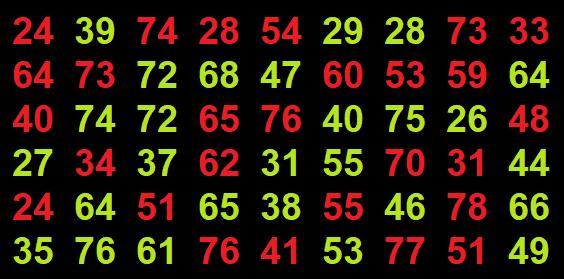

Print outputs:
Red numbers: {
Green numbers: '

==== Agent is executing the code below:
red_numbers = visualizer(question="Get the list of red numbers from the image", image_path='data/gaia/validation/df6561b2-7ee5-4540-baab-5095f742716a.png')
green_numbers = visualizer(question="Get the list of green numbers from the image", image_path='data/gaia/validation/df6561b2-7ee5-4540-baab-5095f742716a.png')
print("Red numbers:", red_numbers)
print("Green numbers:", green_numbers)
====


data/gaia/validation/df6561b2-7ee5-4540-baab-5095f742716a.png
{'inputs': 'User: Get the list of red numbers from the image<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}
data/gaia/validation/df6561b2-7ee5-4540-baab-5095f742716a.png
{'inputs': 'User: Get the list of green numbers from the image<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}

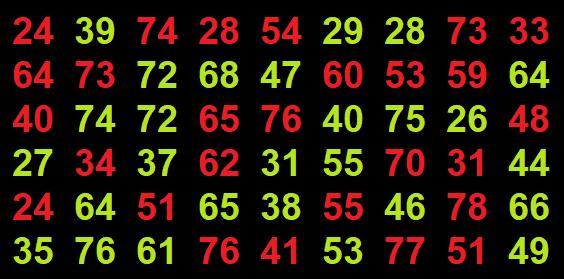
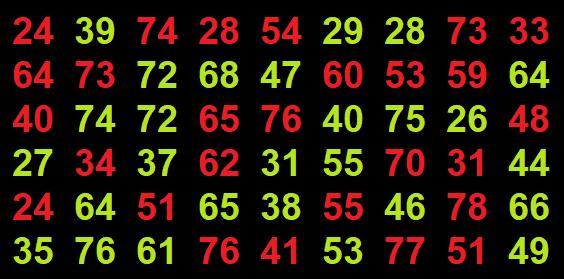

Print outputs:
Red numbers: {'generated_text': ' The red numbers in the image are 24, 39, 74, 72, 64, 73, 68, 47, 60, 53, 59, 64, 74, 72, 65, 76, 40, 75, 26, 48, 27, 34, 37, 62, 31, 55, 70, 31, 44, 153, 61, 53, 77, 51, 49.'}
Green numbers: {'generated_text': ' The green numbers in the image are 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, '}

==== Agent is executing the code below:
import statistics

red_numbers = [int(i) for i in red_numbers['generated_text'].replace("The red numbers in the image are ", "").split(",")]
green_numbers = [int(i) for i in green_numbers['generated_text'].replace("The green numbers in the image are ", "").split(", ")]

red_std_dev = statistics.pstdev(red_numbers)
green_std_dev = statistics.stdev(green_numbers)

average_std_dev = (red_std_dev + green_std_dev) / 2

print("Average standard deviation:", round(average

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
transcribed_text = transcriber(audio="The Thinking Machine video audio")
print("Transcribed Text:", transcribed_text)
====
Failed while trying to execute the code below:
transcribed_text = transcriber(audio="The Thinking Machine video audio")
print("Transcribed Text:", transcribed_text)
This failed due to the following error:
File not found at The Thinking Machine video audio. If `data` is a string, it must either be a URL or a path to a local file. To pass raw content, please encode it as bytes first.
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 823, in step
    result = self.python_evaluator(code_action, available_tools, state=self.state)
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/python_interpreter.py", line 511, in evaluate_python_code
    line_result = evaluate_ast(node, state, tools)
 

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
script_url = ask_search_agent(question="Where can I find the script for Doctor Who Series 9, Episode 11?")
print("Script URL:", script_url)
====
======== New task ========
Where can I find the script for Doctor Who Series 9, Episode 11?
Calling tool: 'informational_web_search' with arguments: {'query': 'Doctor Who Series 9 Episode 11 script'}
Calling tool: 'final_answer' with arguments: {'answer': 'You can find the script for Doctor Who Series 9, Episode 11, at the following URLs: \n\n https://subslikescript.com/series/Doctor_Who-436992/season-9/episode-11-Heaven_Sent \n\n http://downloads.bbc.co.uk/writersroom/scripts/DW9-EP11-Heaven-Sent.pdf'}
Print outputs:
Script URL: You can find the script for Doctor Who Series 9, Episode 11, at the following URLs: 

 https://subslikescript.com/series/Doctor_Who-436992/season-9/episode-11-Heaven_Sent 

 http://downloads.bbc.co.uk/writersroom/scripts/DW9-EP11-Heaven-Sent.pdf

==== Agent is executing the code

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
asean_info = ask_search_agent(question="What are the ASEAN countries and their capitals according to Wikipedia?")
print("ASEAN countries and capitals:", asean_info)
====
======== New task ========
What are the ASEAN countries and their capitals according to Wikipedia?
Calling tool: 'navigational_web_search' with arguments: {'query': 'ASEAN countries and capitals site:wikipedia.org'}
Calling tool: 'navigational_web_search' with arguments: {'query': 'Capitals of ASEAN countries'}
Calling tool: 'final_answer' with arguments: {'answer': '| Country | Capital |\n|---|---|\n| Brunei | Bandar Seri Begawan |\n| Cambodia | Phnom Penh |\n| Indonesia | Jakarta |\n| Laos | Vientiane |\n| Malaysia | Kuala Lumpur |\n| Myanmar | Naypyidaw |\n| Philippines | Manila |\n| Singapore | Singapore |\n| Thailand | Bangkok |\n| Vietnam | Hanoi |'}
Print outputs:
ASEAN countries and capitals: | Country | Capital |
|---|---|
| Brunei | Bandar Seri Begawan |
| Cambodia | Ph

<class 'str'>


==== Agent is executing the code below:
search_result = ask_search_agent(question="Find compounds in NCATS PubChem compound database with molecular weight of 100 g/mol or less, 6 heavy atoms, 1 or fewer hydrogen bond acceptors, and a complexity between 10 and 15.")
print("Search result:", search_result)
====
======== New task ========
Find compounds in NCATS PubChem compound database with molecular weight of 100 g/mol or less, 6 heavy atoms, 1 or fewer hydrogen bond acceptors, and a complexity between 10 and 15.
Calling tool: 'informational_web_search' with arguments: {'query': 'compounds with molecular weight of 100 g/mol or less, 6 heavy atoms, 1 or fewer hydrogen bond acceptors, and a complexity between 10 and 15 ncats pubchem compound database'}
Calling tool: 'informational_web_search' with arguments: {'query': 'NCATS PubChem Compound'}
Calling tool: 'visit_page' with arguments: {'url': 'https://pubchem.ncbi.nlm.nih.gov/'}
Calling tool: 'visit_page' with arguments: {'url': 'https:/

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
article_text = inspect_file_as_text(question="Read the article", file_path="https://doi.org/10.2979/tex.2008.3.1.44")
print("Article text:", article_text)
====
Failed while trying to execute the code below:
article_text = inspect_file_as_text(question="Read the article", file_path="https://doi.org/10.2979/tex.2008.3.1.44")
print("Article text:", article_text)
This failed due to the following error:
Cannot read an empty file
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 823, in step
    result = self.python_evaluator(code_action, available_tools, state=self.state)
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/python_interpreter.py", line 511, in evaluate_python_code
    line_result = evaluate_ast(node, state, tools)
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/tran

<class 'str'>


==== Agent is executing the code below:
contributors = ask_search_agent(question="Who are the contributors to the version of OpenCV where support was added for the Mask-RCNN model?")
print("Contributors:", contributors)
former_heads_of_government = ask_search_agent(question="Who are the former Chinese heads of government?")
print("Former heads of government:", former_heads_of_government)
====
======== New task ========
Who are the contributors to the version of OpenCV where support was added for the Mask-RCNN model?
Calling tool: 'informational_web_search' with arguments: {'query': 'OpenCV contributors Mask-RCNN support'}
list index out of range
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 423, in extract_action
    split[-2],
IndexError: list index out of range
Error: No 'Action:' token provided in your output.
Your output:
I could not find specific information about the contributor

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
paper1_text = inspect_file_as_text(question="Get the text of the Omar Valencfia-Mendez 2017 paper", file_path="Omar Valencfia-Mendez 2017 paper.pdf")
print("Paper 1 text:", paper1_text)
paper2_text = inspect_file_as_text(question="Get the text of the G. Curt Fiedler's 2002 paper", file_path="G. Curt Fiedler's 2002 paper.pdf")
print("Paper 2 text:", paper2_text)
====
Failed while trying to execute the code below:
paper1_text = inspect_file_as_text(question="Get the text of the Omar Valencfia-Mendez 2017 paper", file_path="Omar Valencfia-Mendez 2017 paper.pdf")
print("Paper 1 text:", paper1_text)
paper2_text = inspect_file_as_text(question="Get the text of the G. Curt Fiedler's 2002 paper", file_path="G. Curt Fiedler's 2002 paper.pdf")
print("Paper 2 text:", paper2_text)
This failed due to the following error:
[Errno 2] No such file or directory: 'Omar Valencfia-Mendez 2017 paper.pdf'
Traceback (most recent call last):
  File "/Users/aymeric/Docume

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
document_text = inspect_file_as_text(question="Read the document", file_path='data/gaia/validation/cffe0e32-c9a6-4c52-9877-78ceb4aaa9fb.docx')
print("Document text:", document_text)
====
Print outputs:
Document text: The answer is there are twelve employees.

==== Agent is executing the code below:
employee_profiles = inspect_file_as_text(question="Get the profiles of all employees including their names and three likes or hobbies", file_path='data/gaia/validation/cffe0e32-c9a6-4c52-9877-78ceb4aaa9fb.docx')
print("Employee profiles:", employee_profiles)
====
Print outputs:
Employee profiles: **Employee Profiles:**

- Harry: Enjoys playing guitar, hiking, and cooking different types of cuisine.

- Rebecca: Loves reading classical literature, practicing yoga, and spending time with her pet dog.

- Georgette: Is an avid runner, enjoys painting landscapes, and loves trying new coffee blends.

- Micah: Enthusiastic about video games, playing chess, and

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
first_ng_short = ask_search_agent(question="What is the first National Geographic short on YouTube that was ever released according to the Monterey Bay Aquarium website?")
print("First NG short:", first_ng_short)
====
======== New task ========
What is the first National Geographic short on YouTube that was ever released according to the Monterey Bay Aquarium website?
Calling tool: 'navigational_web_search' with arguments: {'query': 'National Geographic Shorts on the Monterey Bay Aquarium website'}
list index out of range
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 423, in extract_action
    split[-2],
IndexError: list index out of range
Error: No 'Action:' token provided in your output.
Your output:
I could not find any information about YouTube or National Geographic shorts on the provided webpage. I suggest searching the Monterey Bay Aquari

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
study_info = ask_search_agent(question="What are the studies published by Manash Pratim Kashyap and PS Fader in customer retention during 2018-2019?")
print("Study info:", study_info)
====
======== New task ========
What are the studies published by Manash Pratim Kashyap and PS Fader in customer retention during 2018-2019?
Calling tool: 'informational_web_search' with arguments: {'query': 'Author: Manash Pratim Kashyap and PS Fader customer retention 2018-2019'}
Calling tool: 'informational_web_search' with arguments: {'query': 'customer retention studies Manash Pratim Kashyap and PS Fader before 2019'}
Calling tool: 'informational_web_search' with arguments: {'query': 'When was How to Project Customer Retention” Revisited: The Role of Duration Dependence Cohort-level retention rates by Kashyap and Fader first published?'}
list index out of range
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transf

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
Ilias_paper = inspect_file_as_text(file_path="Ilias Lagkouvardos's paper", question="What animals are mentioned in the text?")
print("Ilias_paper:", Ilias_paper)
Olga_paper = inspect_file_as_text(file_path="Olga Tapia's paper", question="What animals are mentioned in the text?")
print("Olga_paper:", Olga_paper)
Wikipedia_page = inspect_file_as_text(file_path="Wikipedia page about alvei species", question="What animals are mentioned in the text?")
print("Wikipedia_page:", Wikipedia_page)
====
Failed while trying to execute the code below:
Ilias_paper = inspect_file_as_text(file_path="Ilias Lagkouvardos's paper", question="What animals are mentioned in the text?")
print("Ilias_paper:", Ilias_paper)
Olga_paper = inspect_file_as_text(file_path="Olga Tapia's paper", question="What animals are mentioned in the text?")
print("Olga_paper:", Olga_paper)
Wikipedia_page = inspect_file_as_text(file_path="Wikipedia page about alvei species", question="What an

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
result = ask_search_agent(question="How many High Energy Physics - Lattice articles were listed in January 2020 on Arxiv?")
print("Result:", result)
====
======== New task ========
How many High Energy Physics - Lattice articles were listed in January 2020 on Arxiv?
Calling tool: 'informational_web_search' with arguments: {'query': 'Number of High Energy Physics - Lattice articles on Arxiv January 2020'}
Calling tool: 'navigational_web_search' with arguments: {'query': 'High Energy Physics - Lattice January 2020 arXiv'}
Calling tool: 'visit_page' with arguments: {'url': 'https://arxiv.org/archive/hep-lat/'}
Calling tool: 'final_answer' with arguments: {'answer': 'There were 25 High Energy Physics - Lattice articles listed on Arxiv in January 2020.'}
Print outputs:
Result: There were 25 High Energy Physics - Lattice articles listed on Arxiv in January 2020.

==== Agent is executing the code below:
ps_versions_available = ask_search_agent(question=

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
book_info = visualizer(question="What is the title and author of the book in the image?", image_path="Whitney Museum of American Art's collection with accession number 2022.128")
print("Book info:", book_info)
====
Print outputs:
Book info: None



Whitney Museum of American Art's collection with accession number 2022.128
[Errno 2] No such file or directory: "/Users/aymeric/Documents/Code/agent_reasoning_benchmark/Whitney Museum of American Art's collection with accession number 2022.128"


==== Agent is executing the code below:
photograph_info = ask_search_agent(question="What is the photograph in the Whitney Museum of American Art's collection with accession number 2022.128 about?")
print("Photograph info:", photograph_info)
====
======== New task ========
What is the photograph in the Whitney Museum of American Art's collection with accession number 2022.128 about?
Calling tool: 'navigational_web_search' with arguments: {'query': 'Whitney museum 2022.128'}
Calling tool: 'visit_page' with arguments: {'url': 'https://whitney.org/Collection/Works'}
Calling tool: 'find_on_page_ctrl_f' with arguments: {'search_string': '2022.128'}
Calling tool: 'visit_page' with arguments: {'url': 'https://whitney.org/Collection/search-results?q=2022.128'}
Calling tool: 'informational_web_search' with arguments: {'query': 'Whitney Museum of American Art photographs in the collection'}
Calling tool: 'visit_page' with arguments: {'url': 'https://whitney.org/collection/works/65802'}
Calling t

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
answer = ask_search_agent(question="How to decode a text written in reverse?")
print("Decoding method:", answer)
====
======== New task ========
How to decode a text written in reverse?
Calling tool: 'informational_web_search' with arguments: {'query': 'how to decode text written in reverse'}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.textreverse.com/'}
Calling tool: 'visit_page' with arguments: {'url': 'https://www.textreverse.com/'}
Calling tool: 'final_answer' with arguments: {'answer': 'To reverse a text, use a reverse text generator website such as https://www.textreverse.com/.'}
Print outputs:
Decoding method: To reverse a text, use a reverse text generator website such as https://www.textreverse.com/.

==== Agent is executing the code below:
original_task = ".rewsna eht sa tfel drow eht fo etisoppo eht etirw,ecnetnes siht dnatsrednu uoy fI"
reversed_task = original_task[::-1]
print("Reversed task:", reversed_task)
====

<class 'transformers.agents.agent_types.AgentText'>


==== Agent is executing the code below:
lord_of_the_rings_html = ask_search_agent(question="Get HTML of English Wikipedia page on The Lord of the Rings book as of July 3, 2023")
print("Lord of the Rings HTML:", lord_of_the_rings_html)
a_song_of_ice_and_fire_html = ask_search_agent(question="Get HTML of English Wikipedia page on A Song of Ice and Fire book series as of July 3, 2023")
print("A Song of Ice and Fire HTML:", a_song_of_ice_and_fire_html)
====
======== New task ========
Get HTML of English Wikipedia page on The Lord of the Rings book as of July 3, 2023
Calling tool: 'navigational_web_search' with arguments: {'query': 'Lord of the Rings book Wikipedia'}
Calling tool: 'visit_page' with arguments: {'url': 'https://en.wikipedia.org/wiki/The_Lord_of_the_Rings'}
Calling tool: 'final_answer' with arguments: {'answer': "Please find below the HTML of the English Wikipedia page on 'The Lord of the Rings' book as of July 3, 2023: \n\n<html>\n<head>\n    <title>The Lord of the Rings - Wi

<class 'str'>


==== Agent is executing the code below:
owned_plots = visualizer(question="What are the coordinates of the green cells?", image_path='data/gaia/validation/5cfb274c-0207-4aa7-9575-6ac0bd95d9b2.png')
print("Owned plots:", owned_plots)
====


data/gaia/validation/5cfb274c-0207-4aa7-9575-6ac0bd95d9b2.png
{'inputs': 'User: What are the coordinates of the green cells?<end_of_utterance>\nAssistant:', 'parameters': {'return_full_text': False, 'max_new_tokens': 200}}

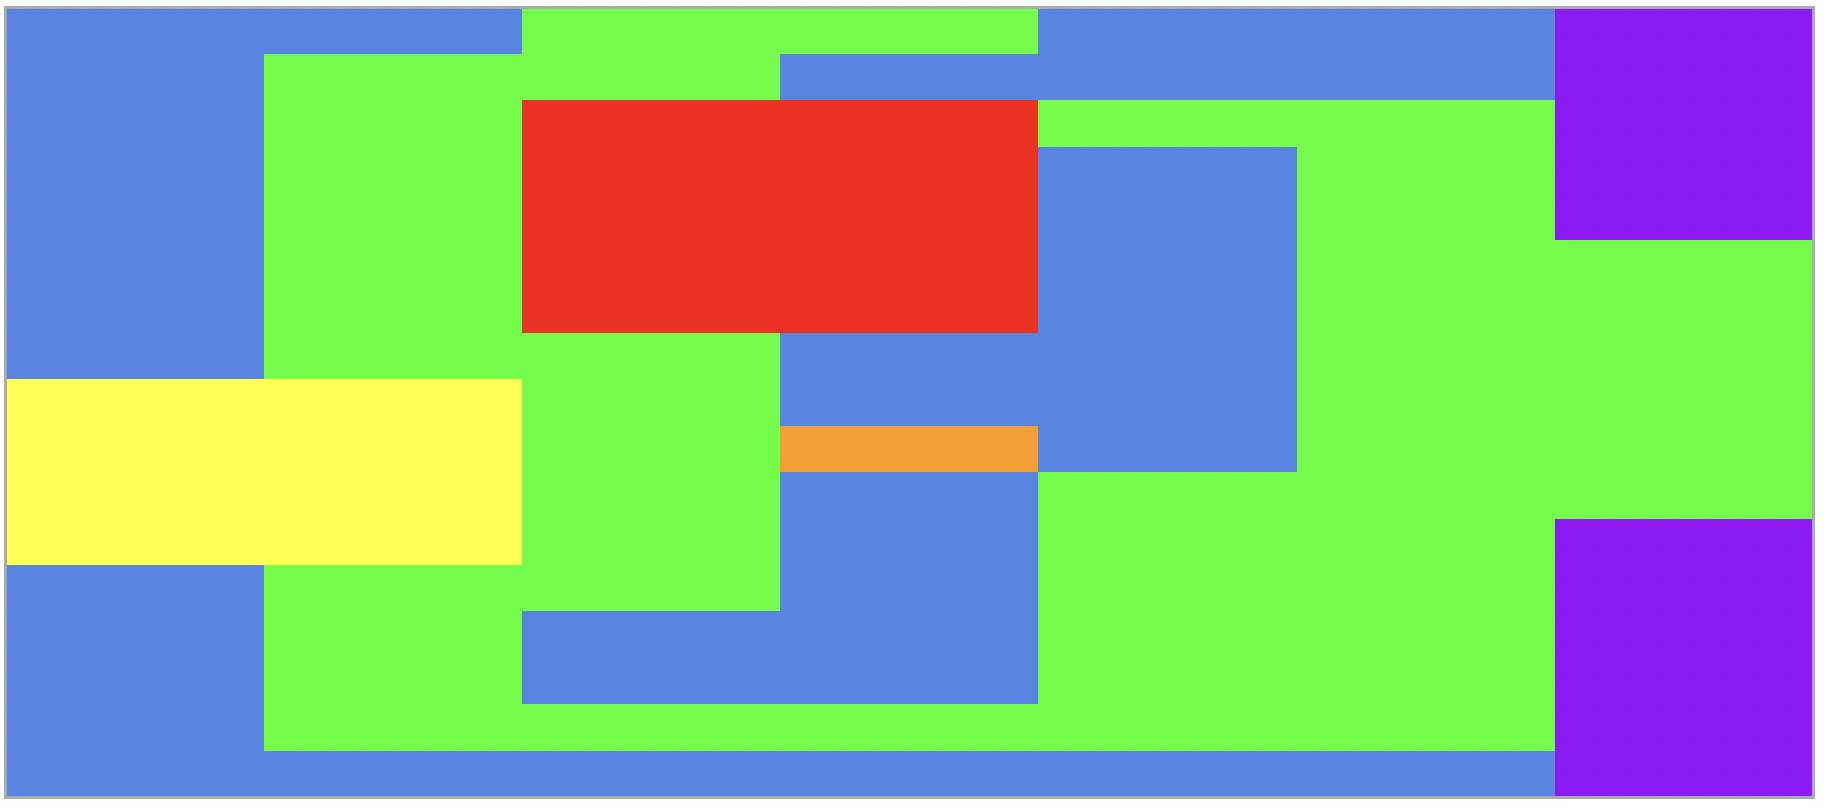

Print outputs:
Owned plots: {'generated_text': ' The green cells are located at the coordinates (0, 0), (0, 1), (1, 0), and (1, 1).'}

==== Agent is executing the code below:
owned_plots_coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
graph = {}
for coord in owned_plots_coords:
    graph[coord] = []
    for other_coord in owned_plots_coords:
        if other_coord!= coord and abs(other_coord[0] - coord[0]) + abs(other_coord[1] - coord[1]) == 1:
            graph[coord].append(other_coord)
print("Graph:", graph)
====
Failed while trying to execute the code below:
owned_plots_coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
graph = {}
for coord in owned_plots_coords:
    graph[coord] = []
    for other_coord in owned_plots_coords:
        if other_coord!= coord and abs(other_coord[0] - coord[0]) + abs(other_coord[1] - coord[1]) == 1:
            graph[coord].append(other_coord)
print("Graph:", graph)
This failed due to the following error:
'Subscript' object has no attribute 'id'
Traceback (most rece

<class 'str'>


==== Agent is executing the code below:
xml_content = inspect_file_as_text(file_path='data/gaia/validation/9b54f9d9-35ee-4a14-b62f-d130ea00317f.zip', question='Read the XML file as text')
print("XML Content:", xml_content)
====
Failed while trying to execute the code below:
xml_content = inspect_file_as_text(file_path='data/gaia/validation/9b54f9d9-35ee-4a14-b62f-d130ea00317f.zip', question='Read the XML file as text')
print("XML Content:", xml_content)
This failed due to the following error:
'utf-8' codec can't decode byte 0x9a in position 11: invalid start byte
Traceback (most recent call last):
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/agents.py", line 823, in step
    result = self.python_evaluator(code_action, available_tools, state=self.state)
  File "/Users/aymeric/Documents/Code/original_transformers/transformers/src/transformers/agents/python_interpreter.py", line 511, in evaluate_python_code
    line_result = evaluate_ast

<class 'str'>


==== Agent is executing the code below:
march_menu = inspect_file_as_text(question="What is the dinner menu?", file_path="https://web.archive.org/web/20210322153939/https://virtuerestaurant.com/dinner-menu")
print("March menu:", march_menu)
april_menu = inspect_file_as_text(question="What is the dinner menu?", file_path="https://web.archive.org/web/20210421153939/https://virtuerestaurant.com/dinner-menu")
print("April menu:", april_menu)
====
invalid pdf header: b'<!DOC'
EOF marker not found
Failed while trying to execute the code below:
march_menu = inspect_file_as_text(question="What is the dinner menu?", file_path="https://web.archive.org/web/20210322153939/https://virtuerestaurant.com/dinner-menu")
print("March menu:", march_menu)
april_menu = inspect_file_as_text(question="What is the dinner menu?", file_path="https://web.archive.org/web/20210421153939/https://virtuerestaurant.com/dinner-menu")
print("April menu:", april_menu)
This failed due to the following error:
Stream has end

In [36]:
from scripts.run_agents import answer_questions

results = await answer_questions(
    eval_ds,
    react_agent_hf,
    "react_code_llama3-70b_07-05_full-gaia-validation",
    output_folder=OUTPUT_DIR,
    agent_call_function=call_transformers,
    add_optional_visualizer_tool=True,
)

# Evaluate

In [19]:
import glob

answer_file_path = f"{OUTPUT_DIR}/answers.jsonl"

result_df = pd.concat(
    [pd.read_json(f, lines=True) for f in glob.glob(f"{OUTPUT_DIR}/*llama3*.jsonl")]
)
result_df = result_df.drop(columns=["start_time", "end_time"])
result_df.to_json(answer_file_path, lines=True, orient="records")

In [20]:
# display(result_df.loc[result_df["agent_name"] == "react_chat_zephyr"].head(5))

# display(result_df.loc[result_df["agent_name"] == "react_code_llama3-70b_29-04_reallybetterprompt", ["question", "prediction", "true_answer", "is_correct", "agent_memory"]])

In [21]:
from scripts.gaia_scorer import question_scorer

result_df["is_correct"] = result_df.apply(
    lambda x: question_scorer(x["prediction"], x["true_answer"]), axis=1
)

Evaluating Failed by reaching max iterations. as a string.
Evaluating Let's try to answer the question manually.

According to Wikipedia, the Moon's perigee (closest approach) is approximately 356400 kilometers.

Eliud Kipchoge's record-making marathon pace is approximately 2.82 meters per second (source: Wikipedia).

Let's calculate the time it would take him to run the distance between the Earth and the Moon at its closest approach:

distance_to_moon = 356400 km = 356400000 m

speed = 2.82 m/s

time = distance / speed
= 356400000 m / (2.82 m/s)
= 126341818 s

 Convert seconds to hours:
= 126341818 s / 3600
= 35100 hours

Rounded to the nearest 1000 hours:
= 35100 hours ≈ 35000 hours

So, it would take Eliud Kipchoge approximately 35000 hours to run the distance between the Earth and the Moon at its closest approach, if he could maintain his record-making marathon pace indefinitely. as a number.
String Let's try to answer the question manually.

According to Wikipedia the Moon's perig

/Users/aymeric/Documents/Code/agent_reasoning_benchmark/scripts/gaia_scorer.py:56: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn(


In [22]:
len(result_df)

1857

In [23]:
def get_elements(x):
    output = x[0]["task"]
    for y in x[1:]:
        try:
            if "observation" in y:
                output += y["llm_output"] + "\nObservation:" + y["observation"]
            else:
                output += y["llm_output"] + "\Error:" + str(y["error"])
        except:
            pass
    return output


result_df["thoughts"] = result_df["intermediate_steps"].apply(lambda x: get_elements(x))

In [24]:
agent_name = "react_code_llama3-70b_29-04_full-gaia-validation-cleaned"

display(
    result_df.loc[
        (result_df["agent_name"] == agent_name) & (result_df["is_correct"] == True),
        ["question", "prediction", "true_answer", "is_correct", "thoughts"],
    ]
)

question  \
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            The object in the British Museum's collection with a museum number of 2012,5015.17 is the shell of a particular mollusk species. According to the abstract of a research article published in Science Advances in 2021, beads made from the shells of this species were found that are at least how many thousands of years old?   
15                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Use density measures from the chemistry materials licensed by Marisa Alviar-Agnew & Henry Agnew under the CK-12 license in LibreText's Introductory Chemistry materials as compiled 08/21/2023.\n\nI have a gallon of honey and a gallon of mayonnaise at 25C. I remove one cup of honey at a time from the gallon of honey. How many times will I need to remove a cup to have the honey weigh less than the mayonaise? Assume the containers themselves weigh the same.   
25                                                                                                                                                                                                                                          I need to fact-check a citation. This is the citation from the bibliography:\n\nGreetham, David. "Uncoupled: OR, How I Lost My Author(s)." Textual Cultures: Texts, Contexts, Interpretation, vol. 3 no. 1, 2008, p. 45-46. Project MUSE, doi:10.2979/tex.2008.3.1.44.\n\nAnd this is the in-line citation:\n\nOur relationship with the authors of the works we read can often be “obscured not by a "cloak of print" but by the veil of scribal confusion and mis-transmission” (Greetham 45-46).\n\nDoes the quoted text match what is actually in the article? If Yes, answer Yes, otherwise, give me the word in my citation that does not match with the correct one (without any article).   
32   My family reunion is this week, and I was assigned the mashed potatoes to bring. The attendees include my married mother and father, my twin brother and his family, my aunt and her family, my grandma and her brother, her brother's daughter, and his daughter's family. All the adults but me have been married, and no one is divorced or remarried, but my grandpa and my grandma's sister-in-law passed away last year. All living spouses are attending. My brother has two children that are still kids, my aunt has one six-year-old, and my grandma's brother's daughter has three kids under 12. I figure each adult will eat about 1.5 potatoes of mashed potatoes and each kid will eat about 1/2 a potato of mashed potatoes, except my second cousins don't eat carbs. The average potato is about half a pound, and potatoes are sold in 5-pound bags. How many whole bags of potatoes do I need? Just give the number.   
39                                                                                                                                                                                                                                                                                                                                              

### Aggregate evaluations

In [25]:
result_df["intermediate_steps"].values[0][0].keys()

dict_keys(['system_prompt', 'task', 'agent_memory'])

In [26]:
selection_name = "react_code_llama3-70b_06-05_full-gaia-validation-idefics"
submission_selection_name = "react_code_llama3-70b_02-05_full-gaia-validation-code"

result_df = result_df.loc[
    result_df["agent_name"].isin(
        [
            selection_name,
        ]
    )
]
len(result_df)

165

In [27]:
result_df["task"].value_counts()

task
2    86
1    53
3    26
Name: count, dtype: int64

In [28]:
# result_df.loc[result_df["true_answer"] == "Rd5"]

In [29]:
tgt_string = "vale"
result_df.loc[result_df["question"].str.contains(tgt_string)][
    ["prediction", "true_answer"]
]

prediction          true_answer
39  (¬A → B) ↔ (A ∨ ¬B)  (¬A → B) ↔ (A ∨ ¬B)

In [30]:
result_df["true_answer_in_prediction"] = result_df.apply(
    lambda x: x["true_answer"] in x["prediction"], axis=1
)

In [31]:
result_df.loc[
    result_df["true_answer_in_prediction"] & ~result_df["is_correct"],
    ["question", "prediction", "true_answer", "is_correct", "thoughts"],
].head(10)

question  \
9   Here's a fun riddle that I think you'll enjoy.\n\nYou have been selected to play the final round of the hit new game show "Pick That Ping-Pong". In this round, you will be competing for a large cash prize. Your job will be to pick one of several different numbered ping-pong balls, and then the game will commence. The host describes how the game works.\n\nA device consisting of a winding clear ramp and a series of pistons controls the outcome of the game. The ramp feeds balls onto a platform. The platform has room for three ping-pong balls at a time. The three balls on the platform are each aligned with one of three pistons. At each stage of the game, one of the three pistons will randomly fire, ejecting the ball it strikes. If the piston ejects the ball in the first position on the platform the balls in the second and third position on the platform each advance one space, and the next ball on the ramp advances to the third position. If the piston ejects the ball in the second position, the ball in the first position is released and rolls away, the ball in the third position advances two spaces to occupy the first position, and the next two balls on the ramp advance to occupy the second and third positions on the platform. If the piston ejects the ball in the third position, the ball in the first position is released and rolls away, the ball in the second position advances one space to occupy the first position, and the next two balls on the ramp advance to occupy the second and third positions on the platform.\n\nThe ramp begins with 100 numbered ping-pong balls, arranged in ascending order from 1 to 100. The host activates the machine and the first three balls, numbered 1, 2, and 3, advance to the platform. Before the random firing of the pistons begins, you are asked which of the 100 balls you would like to pick. If your pick is ejected by one of the pistons, you win the grand prize, $10,000.\n\nWhich ball should you choose to maximize your odds of winning the big prize? Please provide your answer as the number of the ball selected.   
22                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      In Series 9, Episode 11 of Doctor Who, the Doctor is trapped i

In [32]:
result_df.groupby(["agent_name", "task"])["is_correct"].mean()

agent_name                                                task
react_code_llama3-70b_06-05_full-gaia-validation-idefics  1       0.132075
                                                          2       0.046512
                                                          3       0.076923
Name: is_correct, dtype: float64

In [33]:
result_df.groupby(["agent_name"])["is_correct"].mean()

agent_name
react_code_llama3-70b_06-05_full-gaia-validation-idefics    0.078788
Name: is_correct, dtype: float64

In [ ]:
df_inspect = result_df.loc[
    result_df["agent_name"] == "react_code_llama3_26-04-final_answer"
]

In [ ]:
logs = list(df_inspect["intermediate_steps"].values)
memories = [log[-2]["agent_memory"] for log in logs if "agent_memory" in log[-2]]

error_memories = [memory for memory in memories if "error" in str(memory).lower()]
error_memories

In [ ]:
error_memories

In [ ]:
result_df.keys()